In [9]:
import fastf1 as f
import fastf1.plotting as p
import tomli
import numpy as np
import pandas as pd 
import seaborn as sns 
import warnings
from math import ceil
from matplotlib import rcParams, pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import datetime

In [5]:
parent_path = Path.cwd().parent
# connect to cache 
cache_path = parent_path / "Cache"
f.Cache.enable_cache(cache_path)

In [13]:
# plotting setup
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.style.use("dark_background")

In [7]:
# Suppress pandas SettingWithCopy warning
pd.options.mode.chained_assignment = None

# Suppress Seaborn false positive warnings
warnings.filterwarnings("ignore")

In [4]:

def float_to_str(seconds:float):
    """
    Converts a given float value representing seconds to a string representation of time in the format of "min:sec.milisec".

    Parameters:
    ----------
    seconds : float
        The duration in seconds to be formatted as time.

    Returns:
    -------
    str
        The string representation of the time in the format of "min:sec.milisec".

    Examples:
    --------
    >>> format_time(123.45678)
    '2:03.456'
    
    >>> format_time(62.5)
    '1:02.500'
    """
    td = datetime.timedelta(seconds=seconds)
    minutes, seconds = divmod(td.seconds, 60)
    return f"{minutes}:{seconds:02}.{td.microseconds // 1000:03}"

core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 1 [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '44', '31', '27', '24', '23', '22', '21', '20', '18', '16', '14', '11', '10', '4', '2', '77', '81']


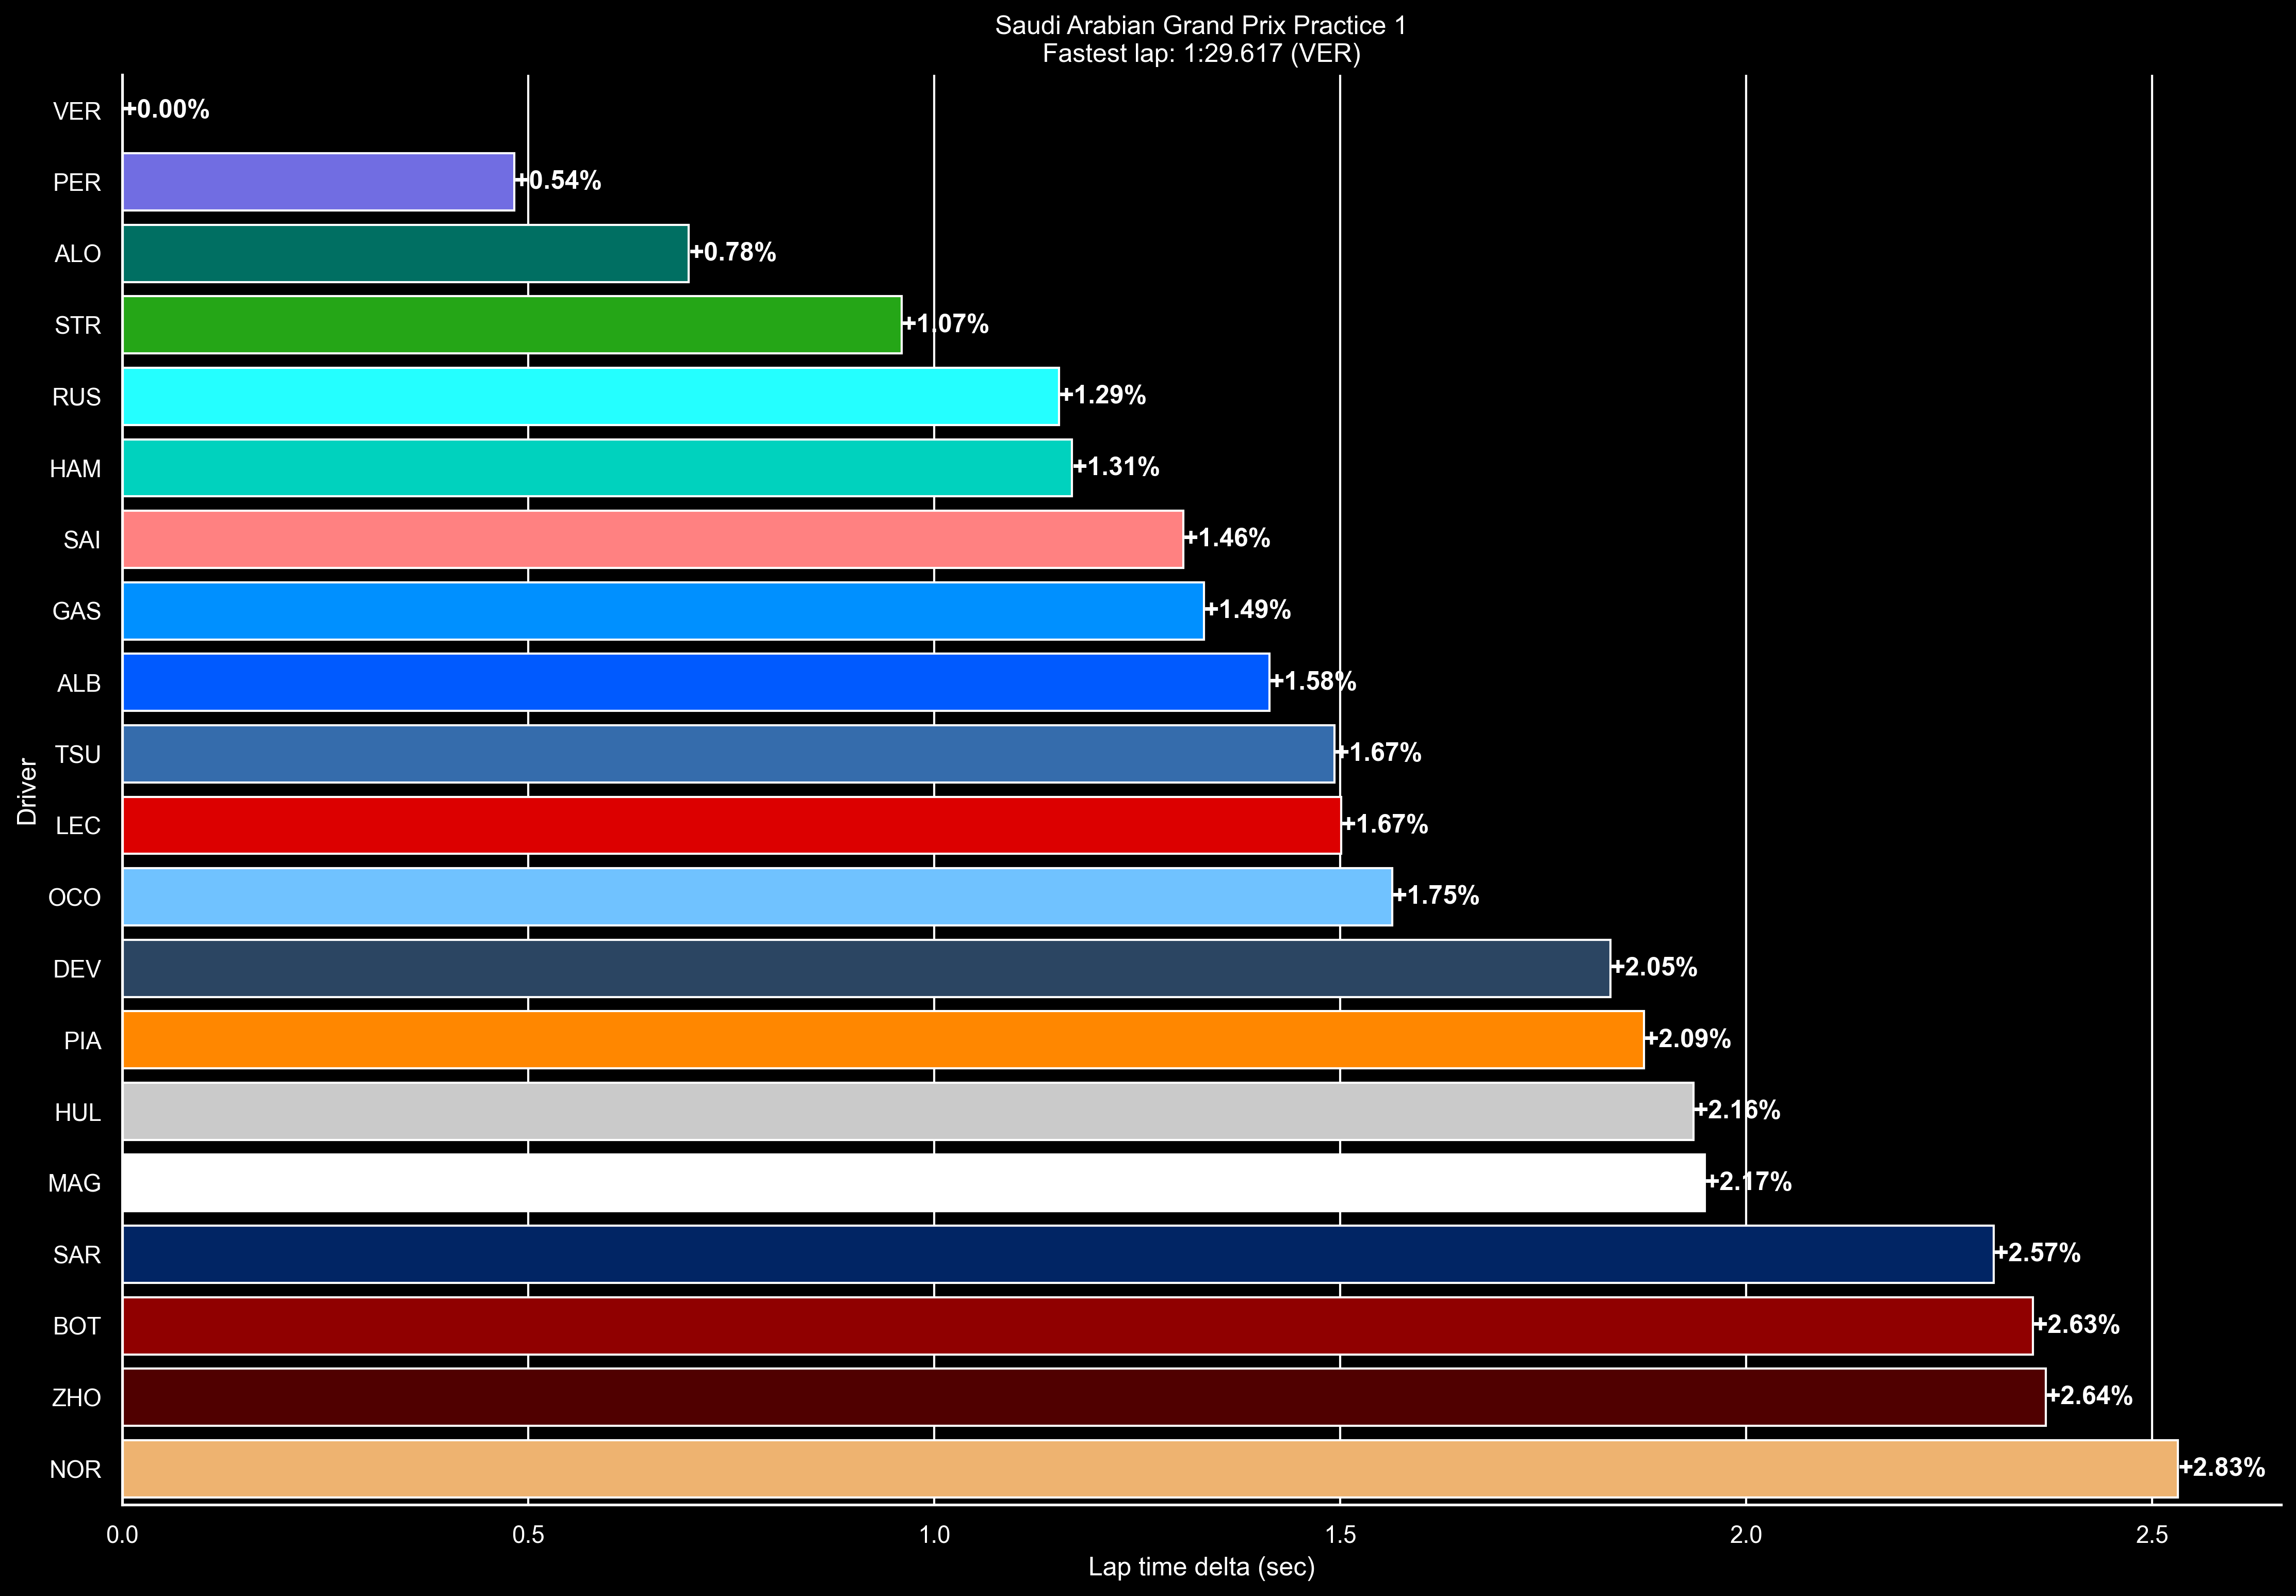

In [16]:
def lap_performance_bar_chart (season: int, gp:int, identifier:str, show_percentage:bool = True, baseline_driver:str = None, only_slower:bool = False):
    """
    Generates a horizontal bar chart comparing the lap times of all drivers in a given session.

    Parameters:
    season (int): the year of the Formula 1 season to analyze
    gp (int): the round number of the race in the season
    identifier (str): the session identifier string, one of 'FP1', 'FP2', 'FP3', 'Q', or 'R'
    show_percentage (bool): whether to show the lap time delta as a percentage of the fastest lap time (default True)
    baseline_driver (str): the name of the driver to use as a baseline for comparison (default None)
    only_slower (bool): whether to only include laps that are slower than the fastest lap (default False)

    Returns:
    None
    """
    session = f.get_session(season, gp, identifier)
    session.load()

    best_laps = session.laps[['LapTime', 'Driver']][session.laps['IsPersonalBest']]
    best_laps['LapTime'] = best_laps['LapTime'].apply(lambda x: x.total_seconds())

    if baseline_driver is not None:
        fastest_lap_time = best_laps.loc[best_laps['Driver'] == baseline_driver, 'LapTime'].values[0]
    else:
        fastest_lap_time = best_laps['LapTime'].min()

    driver = best_laps.loc[best_laps['LapTime'] == fastest_lap_time, 'Driver'].iloc[0]

    if only_slower:
        best_laps = best_laps[best_laps['LapTime'] >= fastest_lap_time]

    best_laps['LapTime'] = best_laps['LapTime'] - fastest_lap_time
    best_laps['Percentage'] = best_laps['LapTime'] / fastest_lap_time * 100

    fig, ax = plt.subplots(figsize=(18, 12))
    best_laps = best_laps.sort_values(by='LapTime',ascending=True)
    best_laps.reset_index(inplace=True)
    colors = [p.driver_color(driver)for driver in best_laps['Driver']]

    colors_rgba = [mcolors.to_rgba(c) for c in colors]
    sns.barplot(x='LapTime', y='Driver', data=best_laps, palette=colors_rgba, orient='h', saturation=1)

    if show_percentage:
        for index, row in best_laps[['LapTime','Percentage']].iterrows():
            sign = '+'
            offset = row['LapTime']
            if row['Percentage'] < 0:
                sign = ''
                offset = 0
            label = "{}{:.2f}%".format(sign,row['Percentage'])
            plt.text(offset, index, label, {'va':'center','fontweight':'bold'})

    plt.xlabel('Lap time delta (sec)')
    event_name = f"{session.event.EventName} {session.event.get_session_name(identifier)}"

    if baseline_driver is None:
        plt.title(event_name + f'\nFastest lap: {float_to_str(fastest_lap_time)} ({driver})')
    else:
        plt.title(event_name + f'\nPace relative to: {float_to_str(fastest_lap_time)} ({driver})')

    #TODO make background lines darker
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


lap_performance_bar_chart(season=2023, gp=2, identifier='Fp1',show_percentage = True, baseline_driver=None, only_slower=False)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 1 [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '44', '31', '27', '24', '23', '22', '21', '20', '18', '16', '14', '11', '10', '4', '2', '77', '81']


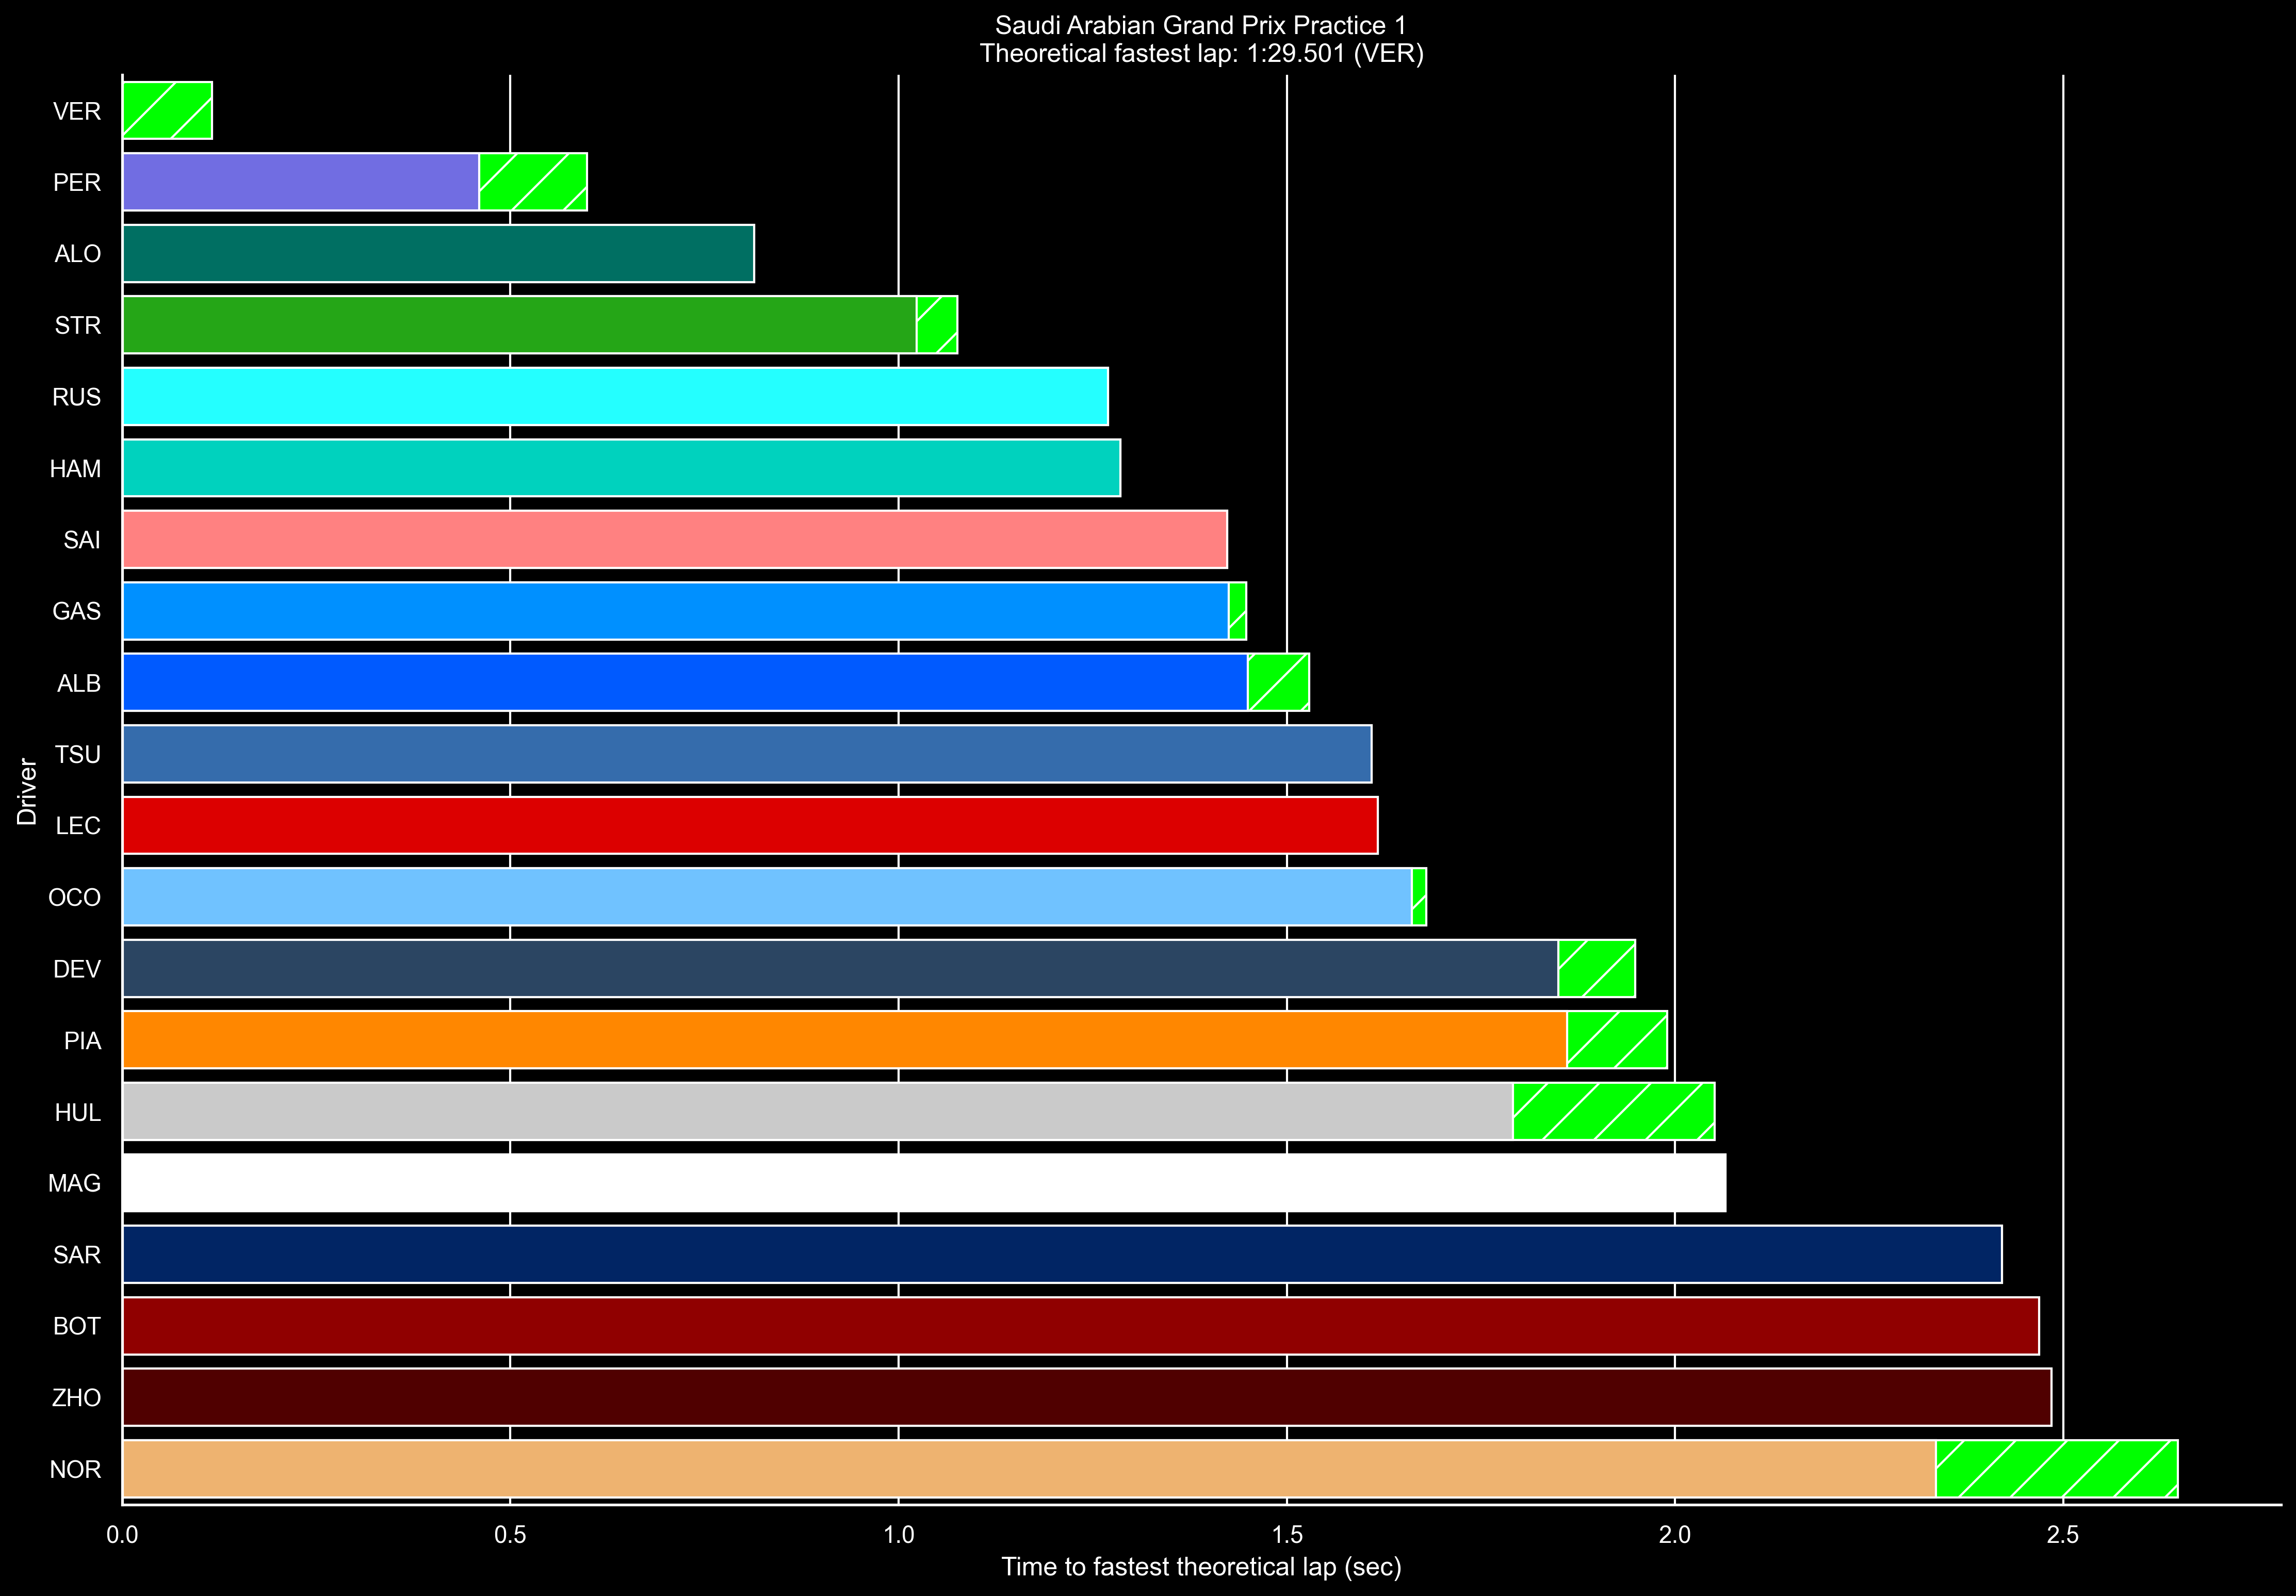

In [64]:
def theoretical_time_delta(season: int, gp:int, identifier:str, label_delta:bool = True):
    """Calculates the delta between lap times and the fastest theoretical lap time and plots the results as a bar chart.

    Args:
        season (int): The season year.
        gp (int): The grand prix number.
        identifier (str): The session identifier.
        label_delta (bool, optional): If True, label the bar chart with the delta values. Defaults to True.

    Returns:
        None
    """
    session = f.get_session(season, gp, identifier)
    session.load()
    def sum_of_min_sector_times(group):
        min_sector_times = group[['Sector1Time', 'Sector2Time', 'Sector3Time']].min()

        sum = min_sector_times['Sector1Time'].total_seconds()
        sum += min_sector_times['Sector2Time'].total_seconds()
        sum += min_sector_times['Sector3Time'].total_seconds()
        return sum

    result = pd.DataFrame(session.laps.groupby('Driver').apply(sum_of_min_sector_times))
    best_laps = session.laps[['LapTime', 'Driver']][session.laps['IsPersonalBest']]
    best_laps = pd.merge(result, best_laps, on='Driver')
    best_laps = best_laps.rename(columns={0: 'Theoretical'})

    fastest_lap_time = best_laps['Theoretical'].min()
    best_laps['LapTime'] = best_laps['LapTime'].apply(lambda x: x.total_seconds())

    driver = best_laps.loc[best_laps['Theoretical'] == fastest_lap_time, 'Driver'].iloc[0]

    best_laps['DeltaFastest'] = best_laps['LapTime'] - fastest_lap_time
    best_laps['DeltaSelf'] = best_laps['LapTime'] - best_laps['Theoretical']
    best_laps['Bar'] = best_laps['DeltaFastest']  - best_laps['DeltaSelf']

    fig, ax = plt.subplots(figsize=(18, 12))
    best_laps = best_laps.sort_values(by='LapTime',ascending=True)
    best_laps.reset_index(inplace=True)
    colors = [p.driver_color(driver)for driver in best_laps['Driver']]

    colors_rgba = [mcolors.to_rgba(c) for c in colors]
    sns.barplot(x='DeltaFastest', y='Driver', data=best_laps,color='#00FF00' , orient='h', saturation=1, hatch='/')
    sns.barplot(x='Bar', y='Driver', data=best_laps, palette=colors_rgba, orient='h', saturation=1)

    if label_delta:
        for index, row in best_laps.iterrows():
            if row['DeltaSelf'] > .001:
                # sign = '+'
                offset = row['DeltaFastest']
                # if row['Percentage'] < 0:
                #     sign = ''
                #     offset = 0
                label = "{:.3f}s off".format(row['DeltaSelf'])
                plt.text(offset, index, label, {'va':'center','fontweight':'bold'})
    
    plt.xlabel('Time to fastest theoretical lap (sec)')
    event_name = f"{session.event.EventName} {session.event.get_session_name(identifier)}"

    plt.title(event_name + f'\nTheoretical fastest lap: {float_to_str(fastest_lap_time)} ({driver})')

    #TODO make background lines darker
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
theoretical_time_delta(season=2023, gp=2, identifier='Fp1', label_delta=False)

In [ ]:
session = f.get_session(2023, 2, 'Fp1')
session.load()
def sum_of_min_sector_times(group):
  min_sector_times = group[['Sector1Time', 'Sector2Time', 'Sector3Time']].min()

  sum = min_sector_times['Sector1Time'].total_seconds()
  sum += min_sector_times['Sector2Time'].total_seconds()
  sum += min_sector_times['Sector3Time'].total_seconds()
  print(sum)
  return sum

result = pd.DataFrame(session.laps.groupby('Driver').apply(sum_of_min_sector_times))
print(result)
best_laps = session.laps[['LapTime', 'Driver']][session.laps['IsPersonalBest']]
best_laps = pd.merge(result, best_laps, on='Driver')
best_laps = best_laps.rename(columns={0: 'Theoretical'})
best_laps.head(10)